# Notebook corresponding to case studies taken from MaveDB

In [1]:
from pathlib import Path

In [2]:
import os
base_path = Path("/cta/share/users/ProteinGym/Clinical_Variants(Substitutions)")
list(base_path.glob("*.csv"))[:5]

[PosixPath('/cta/share/users/ProteinGym/Clinical_Variants(Substitutions)/NP_003110.1.csv'),
 PosixPath('/cta/share/users/ProteinGym/Clinical_Variants(Substitutions)/NP_005076.3.csv'),
 PosixPath('/cta/share/users/ProteinGym/Clinical_Variants(Substitutions)/NP_005493.2.csv'),
 PosixPath('/cta/share/users/ProteinGym/Clinical_Variants(Substitutions)/NP_057097.2.csv'),
 PosixPath('/cta/share/users/ProteinGym/Clinical_Variants(Substitutions)/NP_055790.1.csv')]

In [3]:
import pandas as pd
# Use a generator expression to read and concatenate CSVs
df = pd.concat((pd.read_csv(file) for file in base_path.rglob("*.csv")), ignore_index=True)
# df = pd.read_csv('/cta/share/users/ProteinGym/Clinical_Variants(Substitutions)/NP_055790.1.csv')
df[df["DMS_bin_score"] == "Benign"]

,Unnamed: 0,protein,protein_sequence,mutant,mutated_sequence,DMS_bin_score
0,67567,NP_003110.1,MAVLLLLLRALRRGPGPGPRPLWGPGPAWSPGFPARPGRGRPYMAS...,R13G,MAVLLLLLRALRGGPGPGPRPLWGPGPAWSPGFPARPGRGRPYMAS...,Benign
1,67568,NP_003110.1,MAVLLLLLRALRRGPGPGPRPLWGPGPAWSPGFPARPGRGRPYMAS...,G32E,MAVLLLLLRALRRGPGPGPRPLWGPGPAWSPEFPARPGRGRPYMAS...,Benign
2,67569,NP_003110.1,MAVLLLLLRALRRGPGPGPRPLWGPGPAWSPGFPARPGRGRPYMAS...,K113R,MAVLLLLLRALRRGPGPGPRPLWGPGPAWSPGFPARPGRGRPYMAS...,Benign
5,67572,NP_003110.1,MAVLLLLLRALRRGPGPGPRPLWGPGPAWSPGFPARPGRGRPYMAS...,V183I,MAVLLLLLRALRRGPGPGPRPLWGPGPAWSPGFPARPGRGRPYMAS...,Benign
6,67573,NP_003110.1,MAVLLLLLRALRRGPGPGPRPLWGPGPAWSPGFPARPGRGRPYMAS...,R294H,MAVLLLLLRALRRGPGPGPRPLWGPGPAWSPGFPARPGRGRPYMAS...,Benign
...,...,...,...,...,...,...
62715,18955,NP_004647.1,MNKGWLELESDPGLFTLLVEDFGVKGVQVEEIYDLQSKCQGPVYGF...,S596G,MNKGWLELESDPGLFTLLVEDFGVKGVQVEEIYDLQSKCQGPVYGF...,Benign
62717,18957,NP_004647.1,MNKGWLELESDPGLFTLLVEDFGVKGVQVEEIYDLQSKCQGPVYGF...,V476A,MNKGWLELESDPGLFTLLVEDFGVKGVQVEEIYDLQSKCQGPVYGF...,Benign
62718,18958,NP_004647.1,MNKGWLELESDPGLFTLLVEDFGVKGVQVEEIYDLQSKCQGPVYGF...,T423K,MNKGWLELESDPGLFTLLVEDFGVKGVQVEEIYDLQSKCQGPVYGF...,Benign
62719,18959,NP_004647.1,MNKGWLELESDPGLFTLLVEDFGVKGVQVEEIYDLQSKCQGPVYGF...,N290S,MNKGWLELESDPGLFTLLVEDFGVKGVQVEEIYDLQSKCQGPVYGF...,Benign


# Apply segmentation

In [4]:
import numpy as np
from tokenizers import Tokenizer
from vocabulary_functions import calc_dice_from_encodings

In [27]:
tkz_path = "/cta/share/users/mutbpe/tokenizers/blosum62/hf_uniref50_bpe_51200.json"
tkz1 = Tokenizer.from_file(tkz_path)
tkz_path = "/cta/share/users/mutbpe/tokenizers/blosum62/hf_uniref50_mutbpe_0.7_3_12_0.05_51200.json"
tkz2 = Tokenizer.from_file(tkz_path)

In [5]:
import numpy as np
from scipy.spatial.distance import pdist





'''
Given a Tokenizers encoding offsets offs
Assign each symbol in the sequence its token id
Return the numpy list containing assignments
(Like cluster assignments)
'''
def _offsets_to_cluster(offs):
    seq_len = offs[-1][-1]
    cluster_assign = np.zeros((seq_len, 1))
    for i, (b, e) in enumerate(offs):
        cluster_assign[b:e] = i
    return cluster_assign


# Cluster based rand-index
def calc_rand_index(offs1, offs2):
    clusters1 = _offsets_to_cluster(offs1)
    clusters2 = _offsets_to_cluster(offs2)
    assign_eq = pdist(clusters1, metric='hamming')  # 0 if same, 1 if different
    label_eq = pdist(clusters2, metric='hamming') # 0 if same, 1 if different
    rand_index = np.mean(assign_eq == label_eq)
    return rand_index

# Cluster based dice index
def calc_dice_index(offs1, offs2):
    clusters1 = _offsets_to_cluster(offs1)
    clusters2 = _offsets_to_cluster(offs2)
    assign_eq = pdist(clusters1, metric='hamming')  # 0 if same, 1 if different
    label_eq = pdist(clusters2, metric='hamming') # 0 if same, 1 if different
    # Boolean masks
    same_assign = assign_eq == 0
    same_label = label_eq == 0
    TP = np.sum(same_assign & same_label)
    FP = np.sum(same_assign & ~same_label)
    FN = np.sum(~same_assign & same_label)
    # Jaccard index (ignores TN)
    dice_index = 2*TP / (2*TP + FP + FN + 1e-10)
    return dice_index

# Cluster based jaccard index
def calc_jaccard_index(offs1, offs2):
    clusters1 = _offsets_to_cluster(offs1)
    clusters2 = _offsets_to_cluster(offs2)
    assign_eq = pdist(clusters1, metric='hamming')  # 0 if same, 1 if different
    label_eq = pdist(clusters2, metric='hamming') # 0 if same, 1 if different
    # Boolean masks
    same_assign = assign_eq == 0
    same_label = label_eq == 0
    TP = np.sum(same_assign & same_label)
    FP = np.sum(same_assign & ~same_label)
    FN = np.sum(~same_assign & same_label)
    # Jaccard index (ignores TN)
    jaccard_index = TP / (TP + FP + FN + 1e-10)
    return jaccard_index


# Calc all indices at the same time to avoid redundancy
# Returns rand, dice, jaccard
def calc_all_indices(offs1, offs2):
    clusters1 = _offsets_to_cluster(offs1)
    clusters2 = _offsets_to_cluster(offs2)
    assign_eq = pdist(clusters1, metric='hamming')  # 0 if same, 1 if different
    label_eq = pdist(clusters2, metric='hamming') # 0 if same, 1 if different
    same_assign = assign_eq == 0
    same_label = label_eq == 0
    TP = np.sum(same_assign & same_label)
    FP = np.sum(same_assign & ~same_label)
    FN = np.sum(~same_assign & same_label)
    TN = np.sum(~same_assign & ~same_label)


    jaccard_index = TP / (TP + FP + FN + 1e-10)
    dice_index = 2*TP / (2*TP + FP + FN + 1e-10)
    rand_index = (TP + TN) / (TP + FP + FN + TN)
    
    return rand_index, dice_index, jaccard_index




In [6]:
def batch_calc(tkz, ref_list, target_list):
    scores = np.zeros((len(target_list), 4))
    for i, seq in enumerate(target_list):
        ref_seq = ref_list[i]
        ref_enc = tkz.encode(ref_seq)
        mutated_enc = tkz.encode(seq)
        scores[i, :] = np.array([
                calc_rand_index(ref_enc, mutated_enc),
                calc_dice_from_encodings((ref_enc, mutated_enc)),
                calc_dice_index(ref_enc, mutated_enc),
                calc_jaccard_index(ref_enc, mutated_enc)
        ])
    return scores.mean(axis = 0)

def batch_calc_eq(tkz, ref_list, target_list):
    ct = 0
    for i, seq in enumerate(target_list):
        ref_seq = ref_list[i]
        ref_enc = tkz.encode(ref_seq)
        mutated_enc = tkz.encode(seq)
        if ref_enc.offsets == mutated_enc.offsets:
            ct += 1
    return ct
        
df_benign = df[df["DMS_bin_score"] == "Benign"]
df_patho = df[df["DMS_bin_score"] == "Pathogenic"]
print("BPE Path", batch_calc_eq(tkz1, df_patho["protein_sequence"].to_list()[:30000], df_patho["mutated_sequence"].to_list()[:30000]))
print("PUMA Path", batch_calc_eq(tkz2, df_patho["protein_sequence"].to_list()[:30000], df_patho["mutated_sequence"].to_list()[:30000]))
print("BPE Benign", batch_calc_eq(tkz1, df_benign["protein_sequence"].to_list()[:30000], df_benign["mutated_sequence"].to_list()[:30000]))
print("PUMA Benign", batch_calc_eq(tkz2, df_benign["protein_sequence"].to_list()[:30000], df_benign["mutated_sequence"].to_list()[:30000]))


NameError: name 'tkz1' is not defined

# Notlar
- Ayni kalan proteinler ne kadar ayni iki algoritma arasinda.
- DMS datasindaki, fonksiyonel olarak coherent butun parcalar ile bizim tokenlarimiz arasinda bir uyusma var mi diye incele

In [61]:
encs1 = tkz2.encode_batch(df_patho["protein_sequence"])
encs2 = tkz2.encode_batch(df_patho["mutated_sequence"])

In [7]:
import os
import pickle

# If a small window in the tokenization is being considered
# return the offsets only belonging to that window, (first offset starting from 0)
def take_offsets_subset(offs, lower_idx, upper_idx):
    new_offsets = []
    for s,e in offs:
        start, end = 0, 0
        if e <= lower_idx:
            continue
        if s > upper_idx:
            continue
        if s < lower_idx:
            start = 0
        else:
            start = s - lower_idx
        if e > upper_idx:
            end = upper_idx - lower_idx + 1
        else:
            end = e - lower_idx
        new_offsets.append((start, end))
    return new_offsets

# Calculate all clustering analysis indices around a mutation position centered on a small window
# Window size should be odd
def calc_all_indices_windowed(mutation_pos, window_size, offsets1, offsets2):
    seq_len = offsets1[-1][-1]
    if seq_len <= window_size - 1:
        print(f"less than window_size {window_size}")
        return calc_all_indices(offsets1, offsets2)
    else:
        upper_idx = mutation_pos + window_size//2
        lower_idx = mutation_pos - window_size//2
        if upper_idx >= seq_len:
            lower_idx += -(upper_idx - seq_len + 1)
            upper_idx = seq_len - 1
        if lower_idx < 0:
            upper_idx -= lower_idx
            lower_idx = 0
        new1 = take_offsets_subset(offsets1, lower_idx, upper_idx)
        new2 = take_offsets_subset(offsets2, lower_idx, upper_idx)
        return calc_all_indices(new1, new2)
    
# Calculate Jaccard index around a mutation position centered on a small window
# Window size should be odd
def calc_jaccard_windowed(mutation_pos, window_size, offsets1, offsets2):
    seq_len = offsets1[-1][-1]
    if seq_len <= window_size - 1:
        print(f"less than window_size {window_size}")
        return calc_jaccard_index(offsets1, offsets2)
    else:
        upper_idx = mutation_pos + window_size//2
        lower_idx = mutation_pos - window_size//2
        if upper_idx >= seq_len:
            lower_idx += -(upper_idx - seq_len + 1)
            upper_idx = seq_len - 1
        if lower_idx < 0:
            upper_idx -= lower_idx
            lower_idx = 0
        new1 = take_offsets_subset(offsets1, lower_idx, upper_idx)
        new2 = take_offsets_subset(offsets2, lower_idx, upper_idx)
        return calc_jaccard_index(new1, new2)
    
# Calculate Rand index around a mutation position centered on a small window
# Window size should be odd
def calc_rand_windowed(mutation_pos, window_size, offsets1, offsets2):
    seq_len = offsets1[-1][-1]
    if seq_len <= window_size - 1:
        print(f"less than window_size {window_size}")
        return calc_rand_index(offsets1, offsets2)
    else:
        upper_idx = mutation_pos + window_size//2
        lower_idx = mutation_pos - window_size//2
        if upper_idx >= seq_len:
            lower_idx += -(upper_idx - seq_len + 1)
            upper_idx = seq_len - 1
        if lower_idx < 0:
            upper_idx -= lower_idx
            lower_idx = 0
        new1 = take_offsets_subset(offsets1, lower_idx, upper_idx)
        new2 = take_offsets_subset(offsets2, lower_idx, upper_idx)
        return calc_rand_index(new1, new2)
    
from tqdm import tqdm

# Calculate the metrics for whole dataframe
def batch_process_encodings(tkz_path):
    global df
    tkz = Tokenizer.from_file(tkz_path)
    mutants = df["mutant"].to_list()
    encs1 = tkz.encode_batch(df["protein_sequence"])
    encs2 = tkz.encode_batch(df["mutated_sequence"])
    mutants = [int(mut[1:-1]) for mut in mutants]
    total_size = len(mutants)
    out_dict = {
        "rand": np.zeros((total_size, )),
        "windowed_rand": np.zeros((total_size, )),
        "is_eq": np.zeros((total_size, ), dtype=np.bool),
    }
    for i, (enc1, enc2) in tqdm(enumerate(zip(encs1, encs2))):
        offsets1 = enc1.offsets
        offsets2 = enc2.offsets
        if offsets1 == offsets2:
            out_dict["rand"][i] = 1.0
            out_dict["is_eq"][i] = True
        else:
            out_dict["rand"][i] = calc_rand_index(offsets1, offsets2)
            mutation_pos = mutants[i]
            out_dict["windowed_rand"][i] = calc_rand_windowed(mutation_pos, 51, offsets1, offsets2)
    out_dict["mean_rand"] = np.mean(out_dict["rand"])
    out_dict["mean_windowed_rand"] = np.mean(out_dict["windowed_rand"])
    out_dict["total_eq"] = np.sum(out_dict["is_eq"])

    name = os.path.splitext(os.path.basename(tkz_path))[0]
    out_path = os.path.join("./test_outs/", f"{name}.pkl")
    with open(out_path, "wb") as f:
        pickle.dump(out_dict, f)
    return out_dict
    
        

            

In [8]:
import numpy as np
from multiprocessing import Pool
from tokenizers import Tokenizer

# Global read-only DataFrame
df = None

def init_worker(df_shared):
    global df
    df = df_shared

def run_all_tokenizers(df_input, tokenizer_paths, num_workers=4):
    global df
    df = df_input  # set globally once

    with Pool(processes=num_workers, initializer=init_worker, initargs=(df,)) as pool:
        result_paths = pool.map(batch_process_encodings, tokenizer_paths)

    return result_paths

In [9]:
import os
base_path = "/cta/share/users/mutbpe/tokenizers/blosum62/"
tkzs = os.listdir(base_path)
tkzs = list(filter(lambda x: x.startswith("hf"), tkzs))
tkzs = [base_path + p for p in tkzs]
tkzs[:5]

['/cta/share/users/mutbpe/tokenizers/blosum62/hf_uniref50_mutbpe_0.7_3_12_0_800.json',
 '/cta/share/users/mutbpe/tokenizers/blosum62/hf_uniref50_bpe_6400.json',
 '/cta/share/users/mutbpe/tokenizers/blosum62/hf_uniref90pre_mutbpe_0.8_3_12_0.05_51200.json',
 '/cta/share/users/mutbpe/tokenizers/blosum62/hf_uniref90pre_mutbpe_0.9_3_12_0.05_1600.json',
 '/cta/share/users/mutbpe/tokenizers/blosum62/hf_uniref90_mutbpe_0.8_3_12_0.005_1600.json']

In [10]:
# already_calculated = os.listdir("./patho_outs/")
# already_calculated = [s[:-4] for s in already_calculated]
already_calculated = []

In [20]:
tkz_paths = [p for p in tkzs if p not in already_calculated]
run_all_tokenizers(df_patho, tkz_paths, num_workers=50)

32000it [00:33, 962.25it/s] 
32000it [00:33, 953.68it/s] 
32000it [00:35, 913.52it/s] 
32000it [00:37, 847.41it/s] 
16372it [00:37, 456.79it/s] 
22822it [00:40, 995.21it/s] 
32000it [00:40, 782.44it/s] 
32000it [00:42, 755.95it/s] 
32000it [00:43, 738.58it/s] 
32000it [00:44, 724.89it/s] 
22147it [00:44, 480.37it/s] 
5672it [00:10, 190.62it/s]] 
32000it [00:47, 674.57it/s] 
32000it [00:47, 674.42it/s] 
29055it [00:48, 1060.03it/s]
1802it [00:02, 561.39it/s]] 
32000it [00:49, 644.21it/s] 
32000it [00:50, 632.81it/s] 
32000it [00:50, 628.24it/s] 
2534it [00:03, 465.96it/s]] 
28714it [00:51, 1261.00it/s]
26072it [00:51, 485.04it/s] 
32000it [00:51, 620.21it/s] 
32000it [00:52, 612.40it/s] 
32000it [00:52, 613.34it/s] 
32000it [00:53, 600.38it/s] 
32000it [00:53, 593.93it/s] 
28230it [00:54, 1075.03it/s]
32000it [00:55, 581.68it/s] 
32000it [00:54, 583.46it/s] 
32000it [00:55, 578.15it/s] 
32000it [00:55, 573.68it/s] 
32000it [00:56, 570.18it/s] 
32000it [00:57, 554.25it/s] 
32000it [00:57

[{'rand': array([0.99999366, 0.99999049, 0.99998733, ..., 1.        , 0.99998869,
         1.        ], shape=(32000,)),
  'windowed_rand': array([0.99843137, 0.99764706, 0.99686275, ..., 0.        , 0.99764706,
         0.        ], shape=(32000,)),
  'is_eq': array([False, False, False, ...,  True, False,  True], shape=(32000,)),
  'mean_rand': np.float64(0.9999892924343362),
  'mean_windowed_rand': np.float64(0.4260589705882353),
  'total_eq': np.int64(18334)},
 {'rand': array([0.99998416, 0.99999049, 0.99998733, ..., 1.        , 0.99998116,
         0.99999246], shape=(32000,)),
  'windowed_rand': array([0.99607843, 0.99764706, 0.99686275, ..., 0.        , 0.99607843,
         0.99843137], shape=(32000,)),
  'is_eq': array([False, False, False, ...,  True, False, False], shape=(32000,)),
  'mean_rand': np.float64(0.9999793720877914),
  'mean_windowed_rand': np.float64(0.42774321078431377),
  'total_eq': np.int64(18251)},
 {'rand': array([0.99998099, 0.99996198, 0.99997465, ..., 1. 

In [44]:
import os
import pickle
base_path = "./benign_outs_rand/"
all_name_list = os.listdir(base_path)
value_list = []
name_list = []

for name in all_name_list:
    # if name.startswith("hf_uniref50") and "25600" in name:
    if "512000" not in name:
    # if True:
        with open(base_path + name, "rb") as f:
            val = pickle.load(f)
            # print(val["windowed_rand"].shape)
            value_list.append(val)
            name_list.append(name)


In [46]:
all_pairs = list(zip(value_list, name_list))
all_pairs.sort(key = lambda x: x[0]["total_eq"], reverse=True)
for val, name in all_pairs:
    print(val["mean_windowed_rand"], name, val["total_eq"])

0.3735430230933132 hf_uniref50pre_mutbpe_0.9_3_12_0.005_800.pkl 19217
0.3735430230933132 hf_uniref50pre_mutbpe_0.9_3_12_0.05_800.pkl 19217
0.3735430230933132 hf_uniref50pre_mutbpe_0.9_3_12_0_800.pkl 19217
0.37309127758240346 hf_uniref50pre_mutbpe_0.9_3_12_0.005_3200.pkl 19216
0.37318893711030154 hf_uniref50pre_mutbpe_0.9_3_12_0_3200.pkl 19213
0.37381055302324 hf_uniref50_mutbpe_0.9_3_12_0.05_800.pkl 19209
0.37381055302324 hf_uniref50_mutbpe_0.9_3_12_0.005_800.pkl 19209
0.37381055302324 hf_uniref50_mutbpe_0.9_3_12_0_800.pkl 19209
0.373737755068832 hf_uniref50pre_mutbpe_0.9_3_12_0.05_3200.pkl 19196
0.3750176411242077 hf_uniref50_mutbpe_0.8_3_12_0_3200.pkl 19161
0.37512209036314104 hf_uniref50pre_mutbpe_0.8_3_12_0.05_3200.pkl 19157
0.3751989213038032 hf_uniref50_mutbpe_0.8_3_12_0.05_3200.pkl 19155
0.37530686749917197 hf_uniref50_mutbpe_0.8_3_12_0.005_3200.pkl 19152
0.3754857227819692 hf_uniref50pre_mutbpe_0.8_3_12_0.005_3200.pkl 19146
0.3756912774547773 hf_uniref50_mutbpe_0.9_3_12_0.005_1

In [11]:
value_list[2]["jaccard"].shape
len(value_list)

20

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Example setup
# all_pairs = [(val_dict, name), ...]
# val_dict is assumed to contain a key "total_eq"
# Example: all_pairs = [({"total_eq": 0.25}, "A"), ({"total_eq": 0.35}, "B"), ...]

target_name = "hf_uniref50_bpe_25600.pkl"  # Change this to the name you want to highlight

# Extract values and find the target value
values = [val["total_eq"] for val, name in all_pairs]
target_value = next(val["total_eq"] for val, name in all_pairs if name == target_name)

# Create histogram
n, bins, patches = plt.hist(values, bins=20, edgecolor='black')

# Highlight the bin containing the target value
for bin_start, bin_end, patch in zip(bins[:-1], bins[1:], patches):
    if bin_start <= target_value < bin_end:
        patch.set_facecolor('red')
        break  # assuming only one match

# Labeling
plt.xlabel("total_eq")
plt.ylabel("Frequency")
plt.title(f"Histogram of total_eq values\nHighlight: {target_name}")
plt.show()


NameError: name 'all_pairs' is not defined

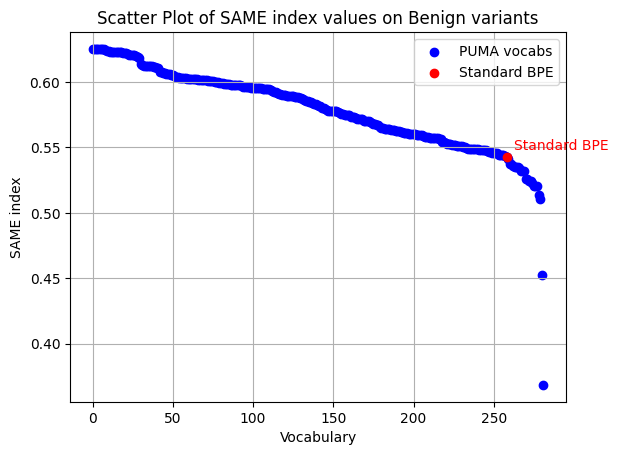

In [35]:
import matplotlib.pyplot as plt

# Prepare data
x = list(range(len(all_pairs)))  # or use np.arange
y = [val["total_eq"]/len(val["rand"]) for val, name in all_pairs]
# y = [val["mean_windowed_rand"] for val, name in all_pairs]

# Extract the target
target_name = "hf_uniref50_bpe_25600.pkl"  # change this to your target
target_index = next(i for i, (val, name) in enumerate(all_pairs) if name == target_name)
target_y = y[target_index]

# Plot all points
plt.scatter(x, y, label='PUMA vocabs', color='blue')

# Highlight the target point
plt.scatter([target_index], [target_y], color='red', label="Standard BPE", zorder=5)

# Optionally annotate
plt.annotate("Standard BPE", (target_index, target_y), textcoords="offset points", xytext=(5,5), ha='left', color='red')

# Labeling
plt.xlabel("Vocabulary")
plt.ylabel("SAME index")
plt.title("Scatter Plot of SAME index values on Benign variants")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:

take_offsets_subset(list(zip(range(100), range(1,101))), 50, 100)

[(0, 1),
 (1, 2),
 (2, 3),
 (3, 4),
 (4, 5),
 (5, 6),
 (6, 7),
 (7, 8),
 (8, 9),
 (9, 10),
 (10, 11),
 (11, 12),
 (12, 13),
 (13, 14),
 (14, 15),
 (15, 16),
 (16, 17),
 (17, 18),
 (18, 19),
 (19, 20),
 (20, 21),
 (21, 22),
 (22, 23),
 (23, 24),
 (24, 25),
 (25, 26),
 (26, 27),
 (27, 28),
 (28, 29),
 (29, 30),
 (30, 31),
 (31, 32),
 (32, 33),
 (33, 34),
 (34, 35),
 (35, 36),
 (36, 37),
 (37, 38),
 (38, 39),
 (39, 40),
 (40, 41),
 (41, 42),
 (42, 43),
 (43, 44),
 (44, 45),
 (45, 46),
 (46, 47),
 (47, 48),
 (48, 49),
 (49, 50)]

In [36]:
offs = tkz1.encode(df_benign["mutated_sequence"].to_list()[0]).offsets
take_offsets_subset(offs, 0, 30)

[(0, 3),
 (3, 8),
 (8, 11),
 (11, 14),
 (14, 18),
 (18, 22),
 (22, 26),
 (26, 29),
 (29, 31)]

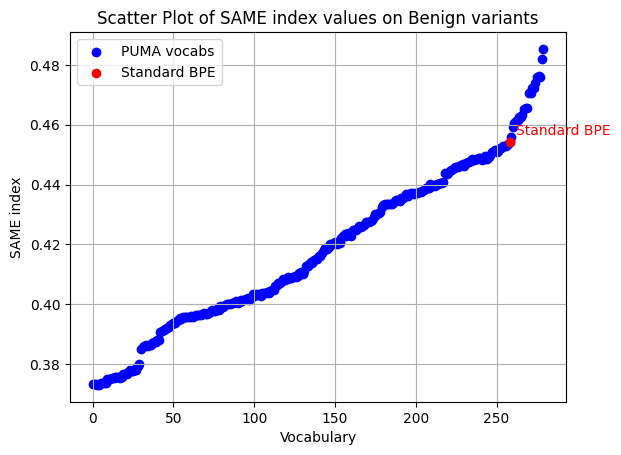

In [48]:
import matplotlib.pyplot as plt
import json
# Prepare data
x = list(range(len(all_pairs)))  # or use np.arange
y = []
# for val, name in all_pairs:
#     with open(f"/cta/share/users/mutbpe/tokenizers/blosum62/{name[3:-4]}.json", "rb") as f:
#         vocab = json.load(f)
#         avg_t_len = np.mean(np.array([len(k) for k in vocab.keys()]))
#         y.append(avg_t_len)
# y = [val["total_eq"]/len(val["rand"]) for val, name in all_pairs]
y = [val["mean_windowed_rand"] for val, name in all_pairs]

# Extract the target
target_name = "hf_uniref50_bpe_25600.pkl"  # change this to your target
target_index = next(i for i, (val, name) in enumerate(all_pairs) if name == target_name)
target_y = y[target_index]

# Plot all points
plt.scatter(x, y, label='PUMA vocabs', color='blue')

# Highlight the target point
plt.scatter([target_index], [target_y], color='red', label="Standard BPE", zorder=5)

# Optionally annotate
plt.annotate("Standard BPE", (target_index, target_y), textcoords="offset points", xytext=(5,5), ha='left', color='red')

# Labeling
plt.xlabel("Vocabulary")
plt.ylabel("SAME index")
plt.title("Scatter Plot of SAME index values on Benign variants")
plt.legend()
plt.grid(True)
plt.show()
